In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ..

/userdata/jgauthier/projects/ideal-word-representations


In [3]:
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
from tqdm.auto import tqdm

from scipy.spatial import ConvexHull
from scipy.spatial.distance import pdist, cdist
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import torch

from src.analysis.state_space import StateSpaceAnalysisSpec, \
    prepare_state_trajectory, aggregate_state_trajectory, flatten_trajectory
from src.utils import concat_csv_with_indices

In [25]:
sns.set_context("talk", font_scale=1.5)

In [21]:
plot_traces = {
    "Word": "w2v2_8/rnn_32-hinge-mAP4/word_broad_10frames",
    "Random": "w2v2_8/randomrnn_32/random",
    "Phoneme": "w2v2_8/rnn_8-weightdecay0.01/phoneme_10frames",
}

In [4]:
df = concat_csv_with_indices("outputs/notebooks/librispeech-train-clean-100/**/geometry/analogy/analogy_results.csv",
                        [lambda p: p.parents[2].name,
                         lambda p: p.parents[3].name, lambda p: p.parents[4].name,
                         lambda p: p.parents[5].name],
                        ["equivalence", "model", "base_model", "dataset"]).reset_index()

In [5]:
df["trace"] = df.base_model + "/" + df.model + "/" + df.equivalence

evaluation_re = r"(\w\d+ .+?)\.txt$"
df["evaluation"] = df.prefix.str.extract(evaluation_re)

In [7]:
df = df[df.trace.isin(plot_traces.values())]
df["Trace"] = df.trace.map({v: k for k, v in plot_traces.items()})

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

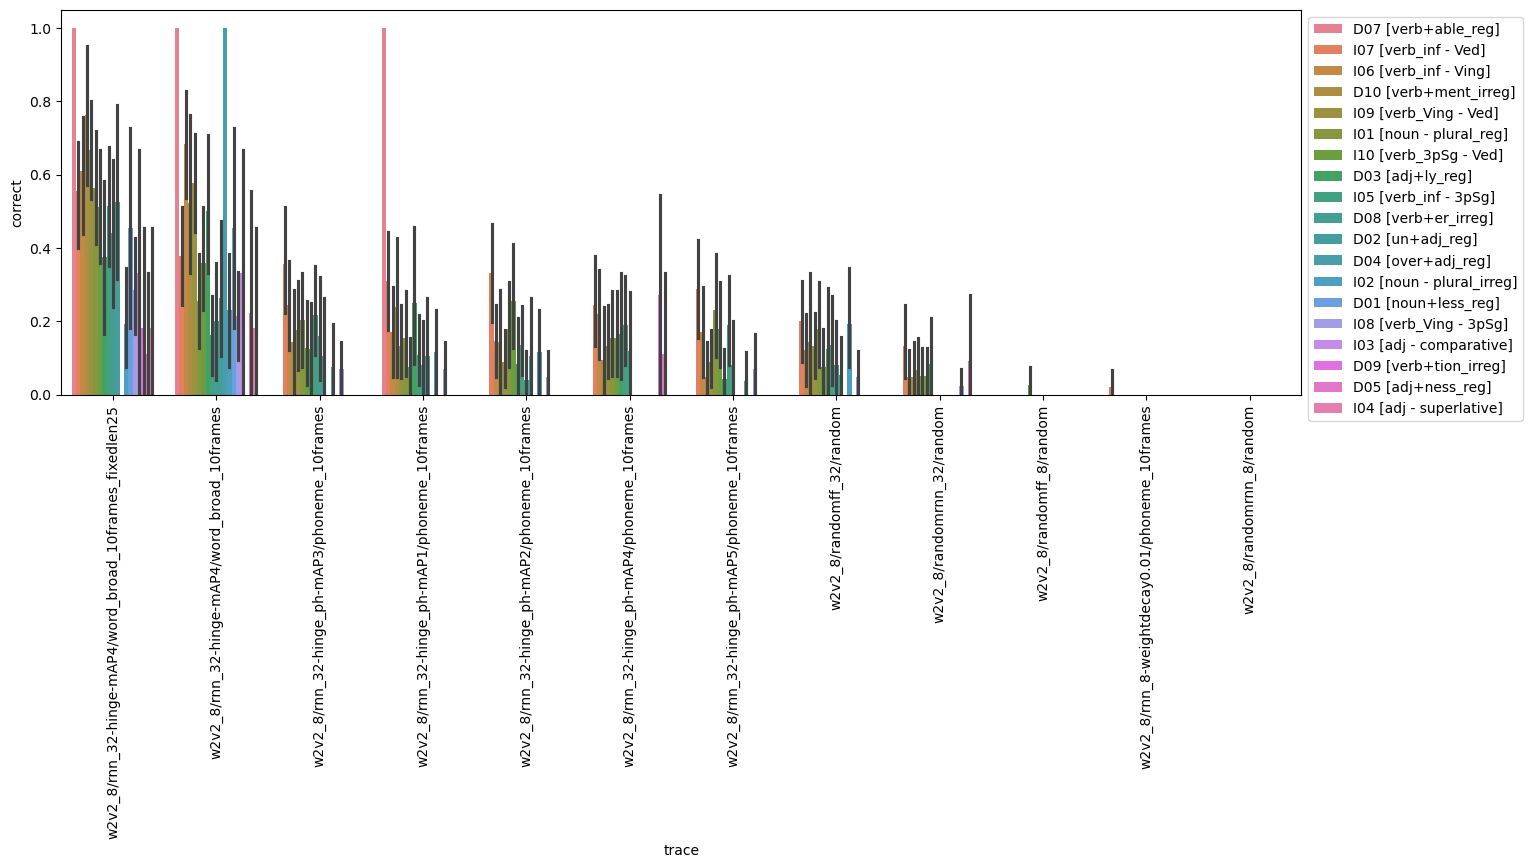

In [8]:
f, ax = plt.subplots(figsize=(16, 5))

ax = sns.barplot(data=df, hue="evaluation", y="correct", x="trace",
                 order=df.groupby("trace").correct.mean().sort_values(ascending=False).index,
                 hue_order=df.groupby("evaluation").correct.mean().sort_values(ascending=False).index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

In [9]:
df.groupby(["trace", "evaluation"]).correct.mean().sort_values(ascending=False).head(30)

trace                                                    evaluation             
w2v2_8/rnn_32-hinge_ph-mAP1/phoneme_10frames             D07 [verb+able_reg]        1.000000
w2v2_8/rnn_32-hinge-mAP4/word_broad_10frames             D04 [over+adj_reg]         1.000000
                                                         D07 [verb+able_reg]        1.000000
w2v2_8/rnn_32-hinge-mAP4/word_broad_10frames_fixedlen25  D07 [verb+able_reg]        1.000000
                                                         D10 [verb+ment_irreg]      0.761905
w2v2_8/rnn_32-hinge-mAP4/word_broad_10frames             I06 [verb_inf - Ving]      0.682927
w2v2_8/rnn_32-hinge-mAP4/word_broad_10frames_fixedlen25  I09 [verb_Ving - Ved]      0.666667
                                                         I06 [verb_inf - Ving]      0.609756
w2v2_8/rnn_32-hinge-mAP4/word_broad_10frames             I09 [verb_Ving - Ved]      0.577778
w2v2_8/rnn_32-hinge-mAP4/word_broad_10frames_fixedlen25  I01 [noun - plural_reg]  

In [10]:
df.groupby(["trace", "evaluation"]).correct_topk.mean().sort_values(ascending=False).head(30)

trace                                                    evaluation             
w2v2_8/rnn_32-hinge-mAP4/word_broad_10frames_fixedlen25  D04 [over+adj_reg]         1.000000
w2v2_8/randomff_32/random                                D04 [over+adj_reg]         1.000000
w2v2_8/rnn_32-hinge-mAP4/word_broad_10frames             D04 [over+adj_reg]         1.000000
                                                         D05 [adj+ness_reg]         1.000000
w2v2_8/rnn_32-hinge_ph-mAP4/phoneme_10frames             D07 [verb+able_reg]        1.000000
w2v2_8/rnn_32-hinge-mAP4/word_broad_10frames             D07 [verb+able_reg]        1.000000
w2v2_8/rnn_32-hinge-mAP4/word_broad_10frames_fixedlen25  D07 [verb+able_reg]        1.000000
w2v2_8/rnn_32-hinge_ph-mAP3/phoneme_10frames             D07 [verb+able_reg]        1.000000
w2v2_8/rnn_32-hinge_ph-mAP2/phoneme_10frames             D04 [over+adj_reg]         1.000000
w2v2_8/rnn_32-hinge_ph-mAP5/phoneme_10frames             D07 [verb+able_reg]      

## Broad study

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

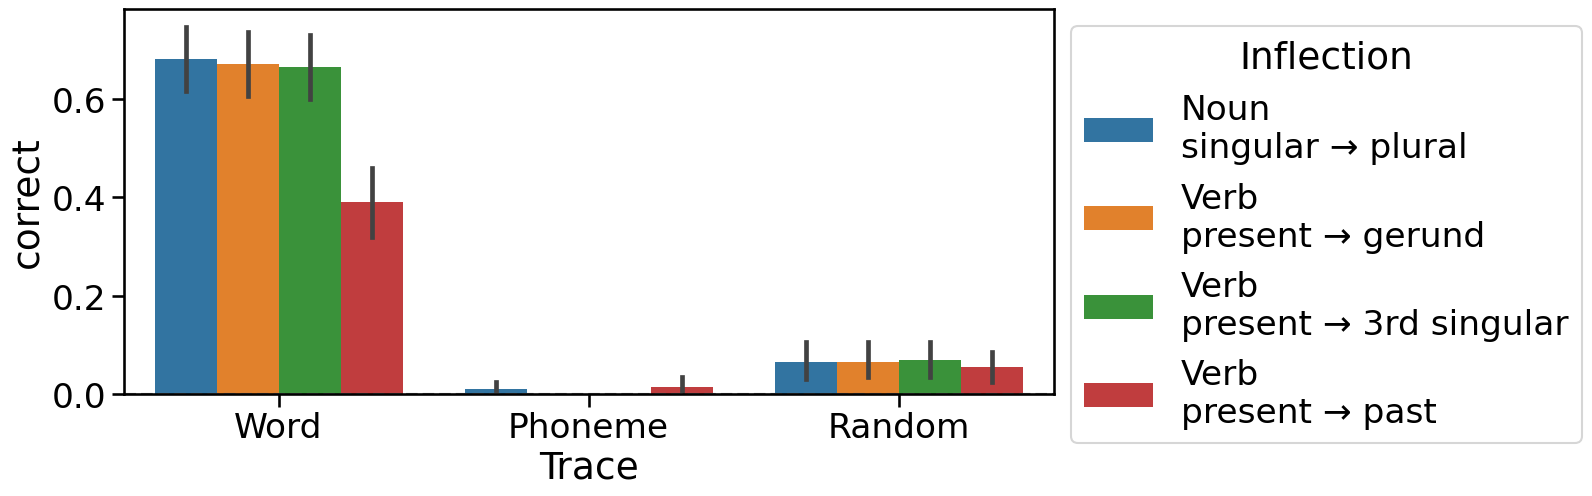

In [40]:
broad_df = concat_csv_with_indices("outputs/notebooks/librispeech-train-clean-100/**/geometry/analogy/broad_inflection_results.csv",
                        [lambda p: p.parents[2].name,
                         lambda p: p.parents[3].name, lambda p: p.parents[4].name,
                         lambda p: p.parents[5].name],
                        ["equivalence", "model", "base_model", "dataset"]).reset_index()
broad_df["trace"] = broad_df.base_model + "/" + broad_df.model + "/" + broad_df.equivalence

broad_df = broad_df[broad_df.trace.isin(plot_traces.values())]
broad_df["Trace"] = broad_df.trace.map({v: k for k, v in plot_traces.items()})
inflection_names = {
    "VBD": "Verb\npresent → past",
    "VBG": "Verb\npresent → gerund",
    "VBZ": "Verb\npresent → 3rd singular",
    "NNS": "Noun\nsingular → plural",
}
broad_df["Inflection"] = broad_df.inflection.map(inflection_names)

f, ax = plt.subplots(figsize=(12, 5))
sns.barplot(data=broad_df, x="Trace", hue="Inflection", hue_order=[inflection_names[code] for code in ["NNS", "VBG", "VBZ", "VBD"]],
            y="correct", ax=ax)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Inflection")
ax.axhline(1 / 20000, color="gray", linestyle="--")

In [51]:
vector_coherence_dfs = {}
for study_trace_name, study_df in tqdm(broad_df.groupby("Trace")):
    study_trace = plot_traces[study_trace_name]
    try:
        difference_vectors = torch.load(f"outputs/notebooks/librispeech-train-clean-100/{study_trace}/geometry/analogy/broad_inflection_difference_vectors.pt")
    except FileNotFoundError:
        continue
    study_df = study_df.set_index(["inflection", "a", "b", "c"]).sort_index()

    # group difference vectors by inflection
    diff_vectors_by_inflection = defaultdict(list)

    for inflection, eval_results in difference_vectors.items():
        for result in eval_results:
            prediction_result = study_df.loc[inflection, result["a"], result["b"], result["c"]]
            if prediction_result.correct:
                diff_vectors_by_inflection[inflection].append(result["difference_vectors"])

    # keep evaluations with 10 or more successes
    diff_vectors_by_inflection = {k: np.concatenate(v) for k, v in diff_vectors_by_inflection.items()
                                  if len(v) >= 10}

    if all(len(v) == 0 for v in diff_vectors_by_inflection.values()):
        print(f"Skipping {study_trace} due to no large collections of correct predictions")
        continue

    vector_coherence_i = {}
    for k, v in diff_vectors_by_inflection.items():
        intra_coherence = pdist(v, metric="cosine").mean()

        inter_vectors = [v_ for k_, v_ in diff_vectors_by_inflection.items() if k != k_]
        if inter_vectors:
            inter_coherence = cdist(v, np.concatenate(inter_vectors), metric="cosine").mean()
        else:
            inter_coherence = np.nan

        vector_coherence_i[k] = (intra_coherence, inter_coherence)

    vector_coherence_df = pd.DataFrame.from_dict(vector_coherence_i, orient="index")
    vector_coherence_df.columns = ["Within inflection", "Between inflection"]
    vector_coherence_dfs[study_trace_name] = vector_coherence_df

  0%|          | 0/3 [00:00<?, ?it/s]

Skipping w2v2_8/rnn_8-weightdecay0.01/phoneme_10frames due to no large collections of correct predictions


In [52]:
vector_coherence_df = pd.concat(vector_coherence_dfs, names=["Trace", "inflection"]).reset_index()

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


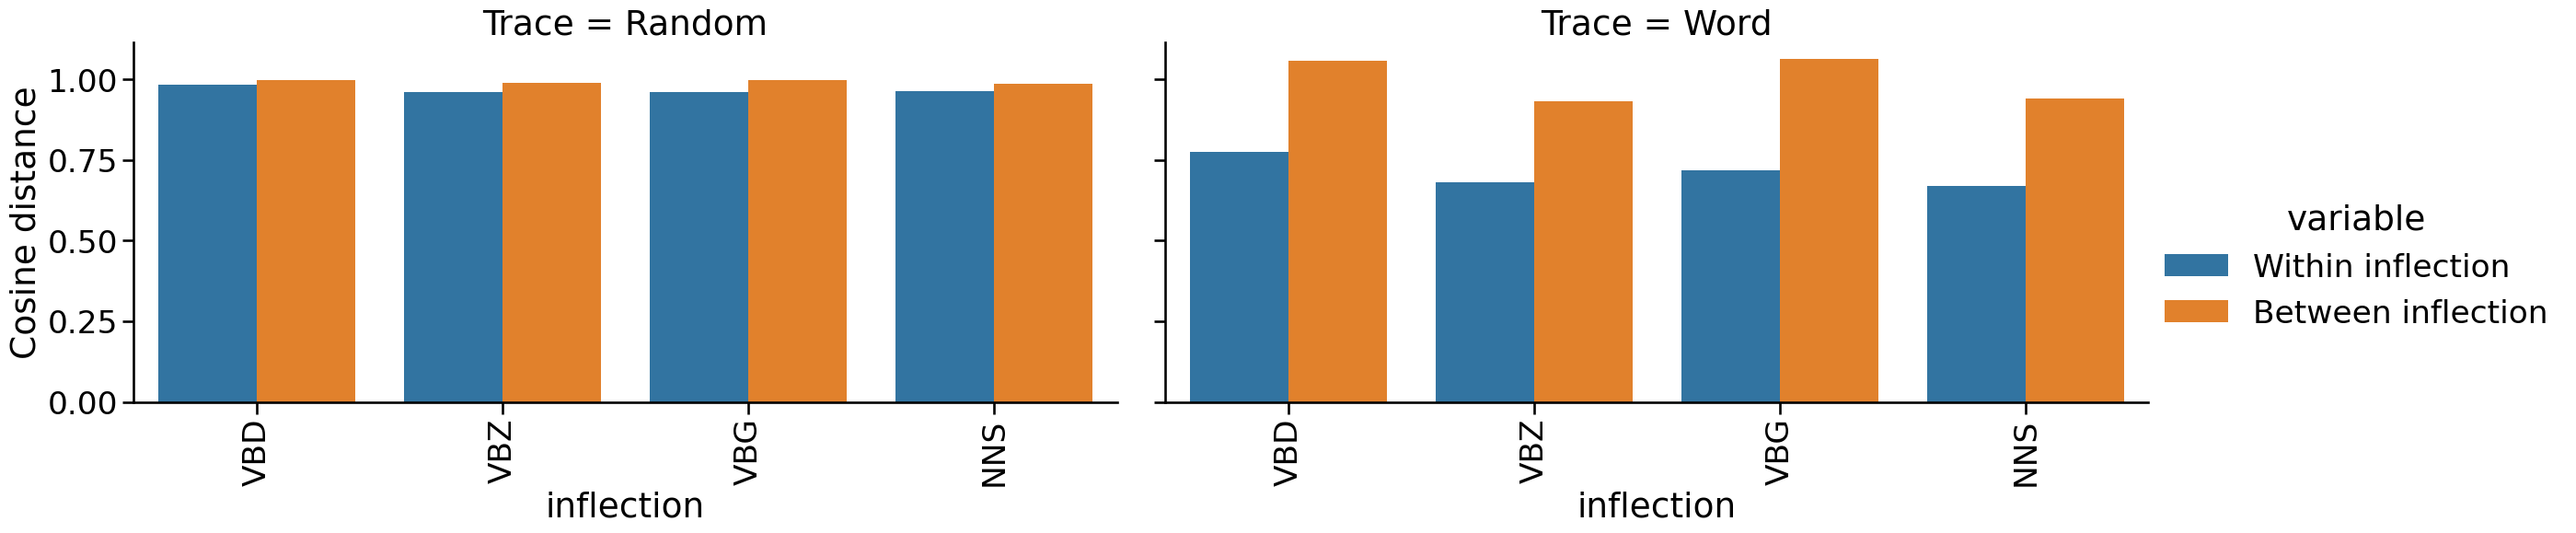

In [53]:
g = sns.catplot(data=vector_coherence_df.melt(id_vars=["Trace", "inflection"], value_name="Cosine distance"),
                col="Trace", col_wrap=2, x="inflection", y="Cosine distance", hue="variable", kind="bar", height=6, aspect=2,
                sharex=False)
# rotate xticklabels
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)

## NNS result compilation

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


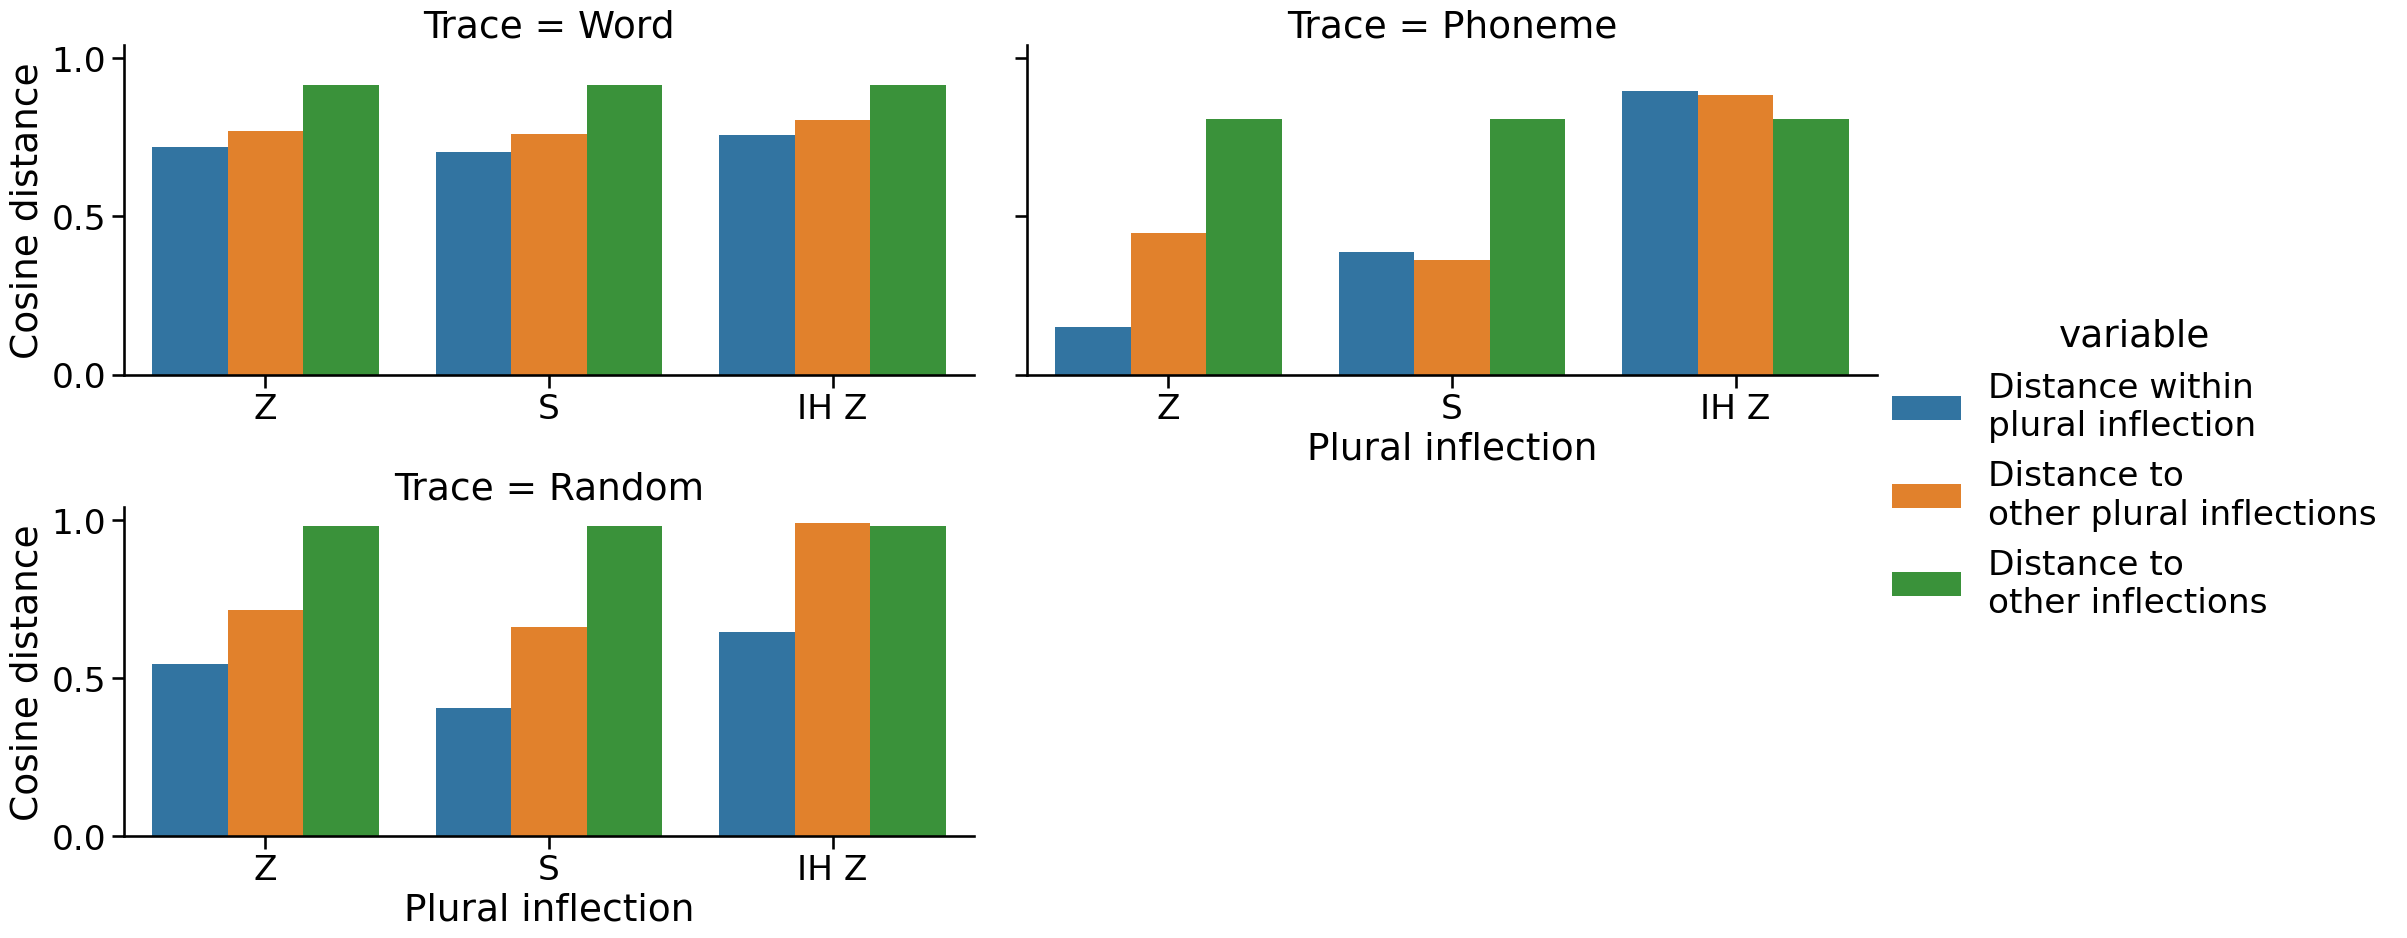

In [61]:
nns_df = concat_csv_with_indices("outputs/notebooks/librispeech-train-clean-100/**/geometry/analogy_dynamic/nns_study.csv",
                        [lambda p: p.parents[2].name,
                         lambda p: p.parents[3].name, lambda p: p.parents[4].name,
                         lambda p: p.parents[5].name],
                        ["equivalence", "model", "base_model", "dataset"]).reset_index()
nns_df["trace"] = nns_df.base_model + "/" + nns_df.model + "/" + nns_df.equivalence
nns_df = nns_df[nns_df.trace.isin(plot_traces.values())]
nns_df["Trace"] = nns_df.trace.map({v: k for k, v in plot_traces.items()})
nns_df = nns_df.rename(columns={"Unnamed: 0": "Plural inflection",
                                "distance_within": "Distance within\nplural inflection",
                                "distance_between": "Distance to\nother plural inflections",
                                "distance_counterfactual": "Distance to\nother inflections"})

ax = sns.catplot(data=nns_df.melt(id_vars=["Trace", "Plural inflection"], value_vars=["Distance within\nplural inflection",
                                                                                     "Distance to\nother plural inflections",
                                                                                     "Distance to\nother inflections"],
                                  value_name="Cosine distance"),
                col="Trace", col_wrap=2, x="Plural inflection", y="Cosine distance", hue="variable", kind="bar",
                height=5, aspect=2, sharex=False)

In [11]:
nns_df

equivalence                  model base_model  \
9                           random            randomff_32     w2v2_8   
10                          random            randomff_32     w2v2_8   
11                          random            randomff_32     w2v2_8   
12             word_broad_10frames      rnn_32-hinge-mAP4     w2v2_8   
13             word_broad_10frames      rnn_32-hinge-mAP4     w2v2_8   
14             word_broad_10frames      rnn_32-hinge-mAP4     w2v2_8   
15  word_broad_10frames_fixedlen25      rnn_32-hinge-mAP4     w2v2_8   
16  word_broad_10frames_fixedlen25      rnn_32-hinge-mAP4     w2v2_8   
17  word_broad_10frames_fixedlen25      rnn_32-hinge-mAP4     w2v2_8   
24                phoneme_10frames  rnn_8-weightdecay0.01     w2v2_8   
25                phoneme_10frames  rnn_8-weightdecay0.01     w2v2_8   
26                phoneme_10frames  rnn_8-weightdecay0.01     w2v2_8   
27                          random           randomrnn_32     w2v2_8   
28                          random           randomrnn_32     w2v2_8   
29                          random           randomrnn_32     w2v2_8   

                        dataset  level_4 Unnamed: 0  distance_within  \
9   librispeech-train-clean-100        0          Z         0.509790   
10  librispeech-train-clean-100        1          S         0.316723   
11  librispeech-train-clean-100        2       IH Z         0.441930   
12  librispeech-train-clean-100        0          Z         0.719534   
13  librispeech-train-clean-100        1          S         0.703519   
14  librispeech-train-clean-100        2       IH Z         0.764705   
15  librispeech-train-clean-100        0          Z         0.832564   
16  librispeech-train-clean-100        1          S         0.791362   
17  librispeech-train-clean-100        2       IH Z         0.741357   
24  librispeech-train-clean-100        0          Z         0.151490   
25  librispeech-train-clean-100        1          S         0.386902   
26  librispeech-train-clean-100        2       IH Z         0.903579   
27  librispeech-train-clean-100        0          Z         0.542724   
28  librispeech-train-clean-100        1          S         0.404280   
29  librispeech-train-clean-100        2       IH Z         0.644351   

    distance_between  distance_counterfactual  \
9           0.652538                 0.981160   
10          0.613648                 0.981160   
11          0.780529                 0.981160   
12          0.772895                 0.915248   
13          0.761983                 0.915248   
14          0.807845                 0.915248   
15          0.898989                 0.994308   
16          0.880484                 0.994308   
17          0.927350                 0.994308   
24          0.450984                 0.814341   
25          0.362837                 0.814341   
26          0.892127                 0.814341   
27          0.714795                 0.984211   
28          0.661729                 0.984211   
29          0.989493                 0.984211   

                                                trace  
9                           w2v2_8/randomff_32/random  
10                          w2v2_8/randomff_32/random  
11                          w2v2_8/randomff_32/random  
12       w2v2_8/rnn_32-hinge-mAP4/word_broad_10frames  
13       w2v2_8/rnn_32-hinge-mAP4/word_broad_10frames  
14       w2v2_8/rnn_32-hinge-mAP4/word_broad_10frames  
15  w2v2_8/rnn_32-hinge-mAP4/word_broad_10frames_f...  
16  w2v2_8/rnn_32-hinge-mAP4/word_broad_10frames_f...  
17  w2v2_8/rnn_32-hinge-mAP4/word_broad_10frames_f...  
24      w2v2_8/rnn_8-weightdecay0.01/phoneme_10frames  
25      w2v2_8/rnn_8-weightdecay0.01/phoneme_10frames  
26      w2v2_8/rnn_8-weightdecay0.01/phoneme_10frames  
27                         w2v2_8/randomrnn_32/random  
28                         w2v2_8/randomrnn_32/random  
29                         w2v2_8/randomrnn_32/random

## Vector study

In [221]:
vector_coherence_dfs = {}
for study_trace, study_df in tqdm(df.groupby("trace")):
    difference_vectors = torch.load(f"outputs/notebooks/librispeech-train-clean-100/{study_trace}/geometry/analogy/analogy_difference_vectors.pt")
    study_df = study_df.set_index("stem")

    # group difference vectors by prefix
    diff_vectors_by_evaluation = defaultdict(list)

    for result in difference_vectors:
        prediction_result = study_df.loc[f"['{result['b']}', '{result['a']}']"]
        if prediction_result.correct:
            diff_vectors_by_evaluation[re.findall(evaluation_re, result["prefix"])[0]].append(result["difference_vectors"])

    # keep evaluations with 5 or more successes
    diff_vectors_by_evaluation = {k: np.concatenate(v) for k, v in diff_vectors_by_evaluation.items()
                                  if len(v) >= 10}

    if all(len(v) == 0 for v in diff_vectors_by_evaluation.values()):
        print(f"Skipping {study_trace} due to no large collections of correct predictions")
        continue

    vector_coherence_i = {}
    for k, v in diff_vectors_by_evaluation.items():
        intra_coherence = pdist(v, metric="cosine").mean()

        inter_vectors = [v_ for k_, v_ in diff_vectors_by_evaluation.items() if k != k_]
        if inter_vectors:
            inter_coherence = cdist(v, np.concatenate(inter_vectors), metric="cosine").mean()
        else:
            inter_coherence = np.nan

        vector_coherence_i[k] = (intra_coherence, inter_coherence)

    vector_coherence_df = pd.DataFrame.from_dict(vector_coherence_i, orient="index")
    vector_coherence_df.columns = ["intra", "inter"]
    vector_coherence_dfs[study_trace] = vector_coherence_df

  0%|          | 0/8 [00:00<?, ?it/s]

Skipping w2v2_8/randomff_32/random due to no large collections of correct predictions
Skipping w2v2_8/randomff_8/random due to no large collections of correct predictions
Skipping w2v2_8/randomrnn_32/random due to no large collections of correct predictions
Skipping w2v2_8/randomrnn_8/random due to no large collections of correct predictions
Skipping w2v2_8/rnn_8-weightdecay0.01/phoneme_10frames due to no large collections of correct predictions
Skipping w2v2_8/rnn_8-weightdecay0.01/syllable_10frames due to no large collections of correct predictions


In [222]:
vector_coherence_df = pd.concat(vector_coherence_dfs, names=["trace", "evaluation"]).reset_index()

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


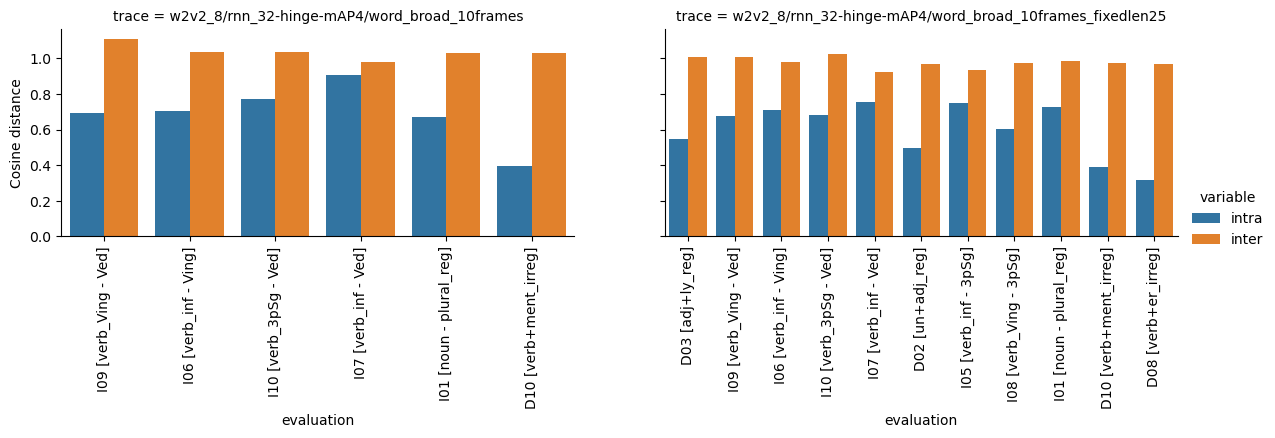

In [226]:
g = sns.catplot(data=vector_coherence_df.melt(id_vars=["trace", "evaluation"], value_vars=["intra", "inter"], value_name="Cosine distance"),
                col="trace", col_wrap=2, x="evaluation", y="Cosine distance", hue="variable", kind="bar", height=3, aspect=2,
                sharex=False)
# rotate xticklabels
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)

## Model specific vector study

In [73]:
study_trace = "w2v2_8/rnn_32-hinge-mAP4/word_broad_10frames"
study_dataset = "librispeech-train-clean-100"
study_df = df[df.trace == study_trace].set_index("stem")
difference_vectors = torch.load(f"outputs/notebooks/{study_dataset}/{study_trace}/geometry/analogy/analogy_difference_vectors.pt")

embeddings_path = f"outputs/model_embeddings/{study_dataset}/{study_trace}/{study_dataset}.npy"
state_space_specs_path = f"outputs/state_space_specs/{study_dataset}/w2v2_8/state_space_specs.pkl"

In [63]:
with open(embeddings_path, "rb") as f:
    model_representations: np.ndarray = np.load(f)
with open(state_space_specs_path, "rb") as f:
    state_space_spec: StateSpaceAnalysisSpec = torch.load(f)["word"]
assert state_space_spec.is_compatible_with(model_representations)

# Use words with this many or more instances to estimate embedding PCA space
pca_freq_min = 15
# Ignore words with this many or more instances when estimating embedding PCA space
pca_freq_max = 10000

# Use at most this many samples of each word in computing PCA (for computational efficiency)
pca_max_samples_per_word = 100

agg_method = "mean"

keep_words = state_space_spec.label_counts
keep_words = keep_words[(keep_words >= pca_freq_min) & (keep_words <= pca_freq_max)].index
state_space_spec = state_space_spec.drop_labels([idx for idx, word in enumerate(state_space_spec.labels) if word not in keep_words])

state_space_spec = state_space_spec.subsample_instances(pca_max_samples_per_word)

In [67]:
trajectory = prepare_state_trajectory(model_representations, state_space_spec, pad=np.nan)
traj_agg = aggregate_state_trajectory(trajectory, state_space_spec, agg_method, keepdims=True)
agg_flat, agg_src = flatten_trajectory(traj_agg)

Aggregating:   0%|          | 0/5204 [00:00<?, ?label/s]

In [68]:
pipeline = make_pipeline(Normalizer(), PCA(n_components=16))
all_trajectories_pca = pipeline.fit_transform(agg_flat)

pca = pipeline.named_steps["pca"]

Text(0, 0.5, 'Cumulative explained variance')

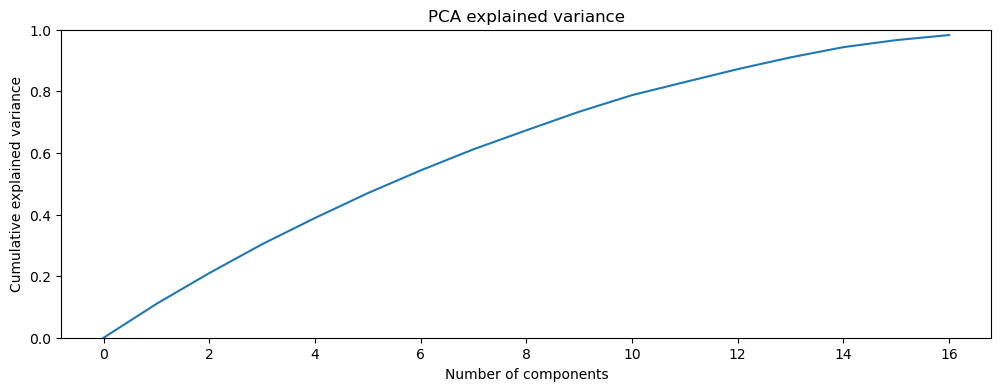

In [69]:
f, ax = plt.subplots(figsize=(12, 4))
ax.plot([0] + np.cumsum(pca.explained_variance_ratio_).tolist())
ax.set_title("PCA explained variance")
ax.set_xlabel("Number of components")
ax.set_ylim((0, 1))
ax.set_ylabel("Cumulative explained variance")

In [125]:
# group difference vectors by prefix
diff_vectors_by_evaluation = defaultdict(list)

for result in difference_vectors:
    prediction_result = study_df.loc[f"['{result['b']}', '{result['a']}']"]
    if prediction_result.correct.item():
        diff_vectors_by_evaluation[re.findall(evaluation_re, result["prefix"])[0]].append(result["difference_vectors"].mean(axis=0))

diff_vectors_by_evaluation = {k: np.array(v) for k, v in diff_vectors_by_evaluation.items()}

In [138]:
study_df.groupby("evaluation").correct.agg(["count", "sum", "mean"])

count  sum      mean
evaluation                                     
D01 [noun+less_reg]           11    6  0.545455
D02 [un+adj_reg]              19    5  0.263158
D03 [adj+ly_reg]              24    9  0.375000
D04 [over+adj_reg]             1    1  1.000000
D05 [adj+ness_reg]             9    1  0.111111
D07 [verb+able_reg]            1    1  1.000000
D08 [verb+er_irreg]           25    5  0.200000
D09 [verb+tion_irreg]         11    1  0.090909
D10 [verb+ment_irreg]         21   11  0.523810
I01 [noun - plural_reg]       39   12  0.307692
I02 [noun - plural_irreg]     26    5  0.192308
I03 [adj - comparative]        6    2  0.333333
I04 [adj - superlative]       11    1  0.090909
I05 [verb_inf - 3pSg]         37    8  0.216216
I06 [verb_inf - Ving]         41   24  0.585366
I07 [verb_inf - Ved]          45   18  0.400000
I08 [verb_Ving - 3pSg]        42    9  0.214286
I09 [verb_Ving - Ved]         45   28  0.622222
I10 [verb_3pSg - Ved]         39   17  0.435897

  0%|          | 0/4 [00:00<?, ?it/s]

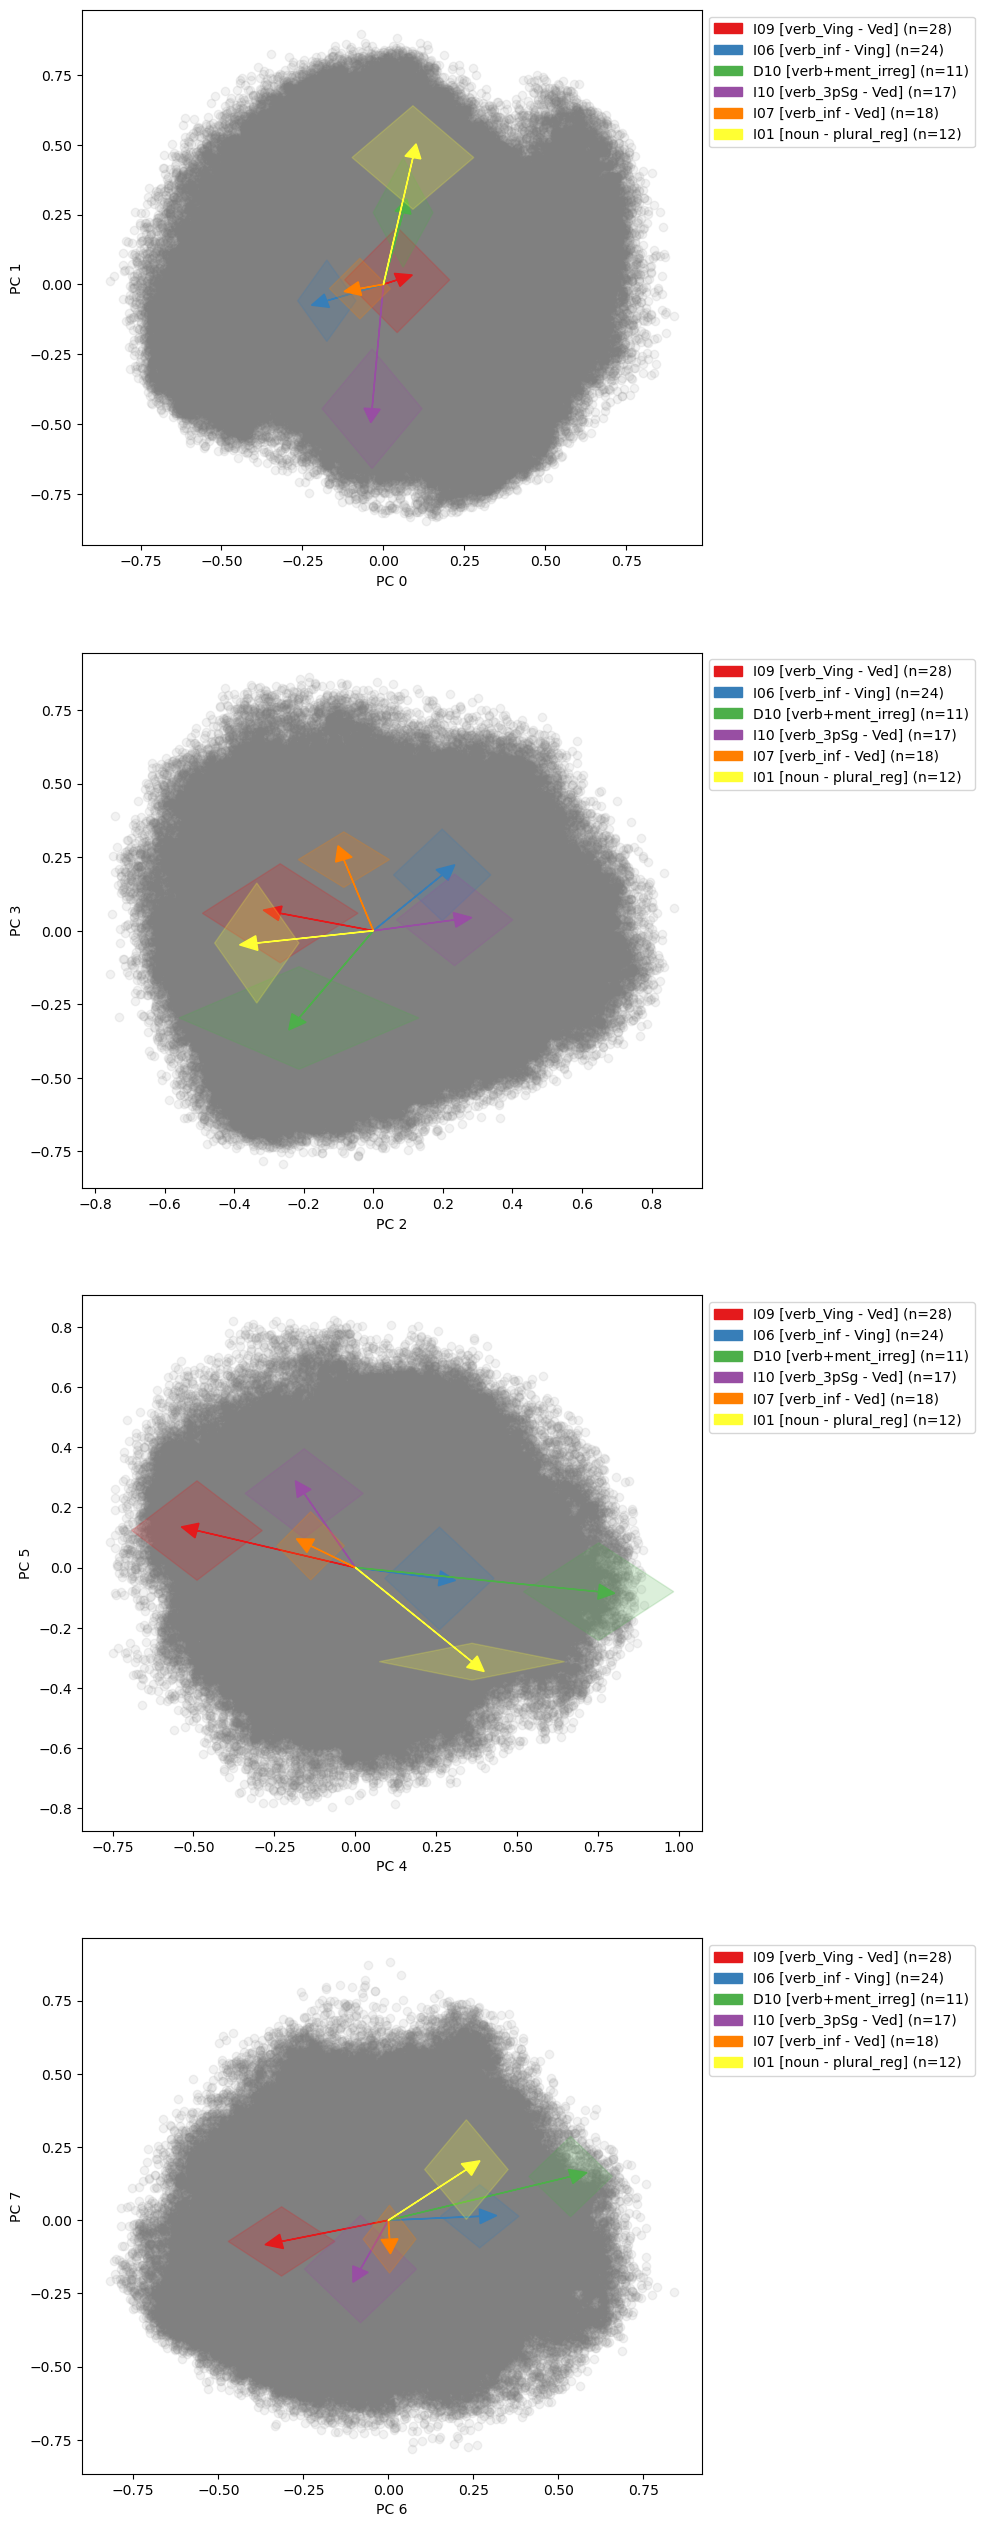

In [159]:
palette = sns.color_palette("Set1")
plot_pc_sets = [[0, 1], [2, 3], [4, 5], [6, 7]]
f, axs = plt.subplots(len(plot_pc_sets), 1, figsize=(8, 8 * len(plot_pc_sets)))
                      
for ax, plot_pcs in zip(tqdm(axs), plot_pc_sets):
    ax.scatter(*all_trajectories_pca[:, plot_pcs].T, alpha=0.1, color="gray")

    # plot by decreasing order of accuracy
    # only show evaluations for which we have >= 10 successes
    evaluation_summary = study_df.groupby("evaluation").correct.agg(["mean", "sum"])
    evaluation_summary = evaluation_summary[evaluation_summary["sum"] >= 10]
    plot_evaluation_order = evaluation_summary.sort_values("mean", ascending=False).index

    for i, evaluation_name in enumerate(plot_evaluation_order):
        vectors = diff_vectors_by_evaluation[evaluation_name]
        vector_mean = vectors.mean(axis=0, keepdims=True)
        vector_std = vectors.std(axis=0, keepdims=True)

        # plot arrow from origin to vector_mean
        color = palette[i % len(palette)]
        ax.arrow(0, 0, *vector_mean[0, plot_pcs], head_width=0.05, head_length=0.05, fc=color, ec=color,
                label=f"{evaluation_name} (n={len(vectors)})")
        
        # plot polygon showing std
        polygon_edges = np.array([
            [vector_mean[0, plot_pcs[0]] + vector_std[0, plot_pcs[0]], vector_mean[0, plot_pcs[1]]],
            [vector_mean[0, plot_pcs[0]], vector_mean[0, plot_pcs[1]] + vector_std[0, plot_pcs[1]]],
            [vector_mean[0, plot_pcs[0]] - vector_std[0, plot_pcs[0]], vector_mean[0, plot_pcs[1]]],
            [vector_mean[0, plot_pcs[0]], vector_mean[0, plot_pcs[1]] - vector_std[0, plot_pcs[1]]],
        ])
        polygon_edges = polygon_edges[ConvexHull(polygon_edges).vertices]
        polygon = plt.Polygon(polygon_edges, alpha=0.2, color=color)
        ax.add_patch(polygon)
        
    ax.set_xlabel(f"PC {plot_pcs[0]}")
    ax.set_ylabel(f"PC {plot_pcs[1]}")
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

## Rough study of inflections

In [208]:
inflection_relations = {
    "gerund": lambda x: x + "ing",
    "past": lambda x: x + "ed",
    "plural": lambda x: x + "s",
}

In [209]:
def analyze_inflection(relation_name, relation_fn):
    label_counts = state_space_spec.label_counts
    infl_bases = [(x, relation_fn(x)) for x in state_space_spec.labels
                  if relation_fn(x) in state_space_spec.labels
                  and label_counts[x] >= pca_freq_min and label_counts[relation_fn(x)] >= pca_freq_min]
    infl_base_idxs = [state_space_spec.labels.index(x) for x, _ in infl_bases]
    infl_derived_idxs = [state_space_spec.labels.index(x) for _, x in infl_bases]

    origins, directions = [], []
    for base_idx, derived_idx in zip(infl_base_idxs, infl_derived_idxs):
        origins.append(all_trajectories_pca[agg_src[:, 0] == base_idx].mean(axis=0))
        directions.append(all_trajectories_pca[agg_src[:, 0] == derived_idx].mean(axis=0) - origins[-1])

    origins = np.array(origins)
    directions = np.array(directions)

    plot_pc_sets = [[0, 1], [2, 3], [4, 5], [6, 7]]
    f, axs = plt.subplots(len(plot_pc_sets), 1, figsize=(8, 8 * len(plot_pc_sets)))
    f.suptitle(relation_name)

    for ax, plot_pcs in zip(axs, plot_pc_sets):
        ax.set_xlabel(f"PC {plot_pcs[0]}")
        ax.set_ylabel(f"PC {plot_pcs[1]}")
        ax.scatter(*all_trajectories_pca[:, plot_pcs].T, alpha=0.01, color="gray")

        mean_direction = directions.mean(axis=0)
        ax.arrow(0, 0, *mean_direction[plot_pcs],
                 head_width=0.05, head_length=0.05, linewidth=3,
                 fc="blue", ec="blue")

        for origin, direction, (base_word, derived_word) in zip(origins, directions, infl_bases):
            ax.arrow(*origin[plot_pcs], *direction[plot_pcs],
                    alpha=0.5, head_width=0.025, head_length=0.025, fc="red", ec="red")
            ax.text(*(origin + direction)[plot_pcs], base_word, size=9, color="red")

    f.tight_layout()

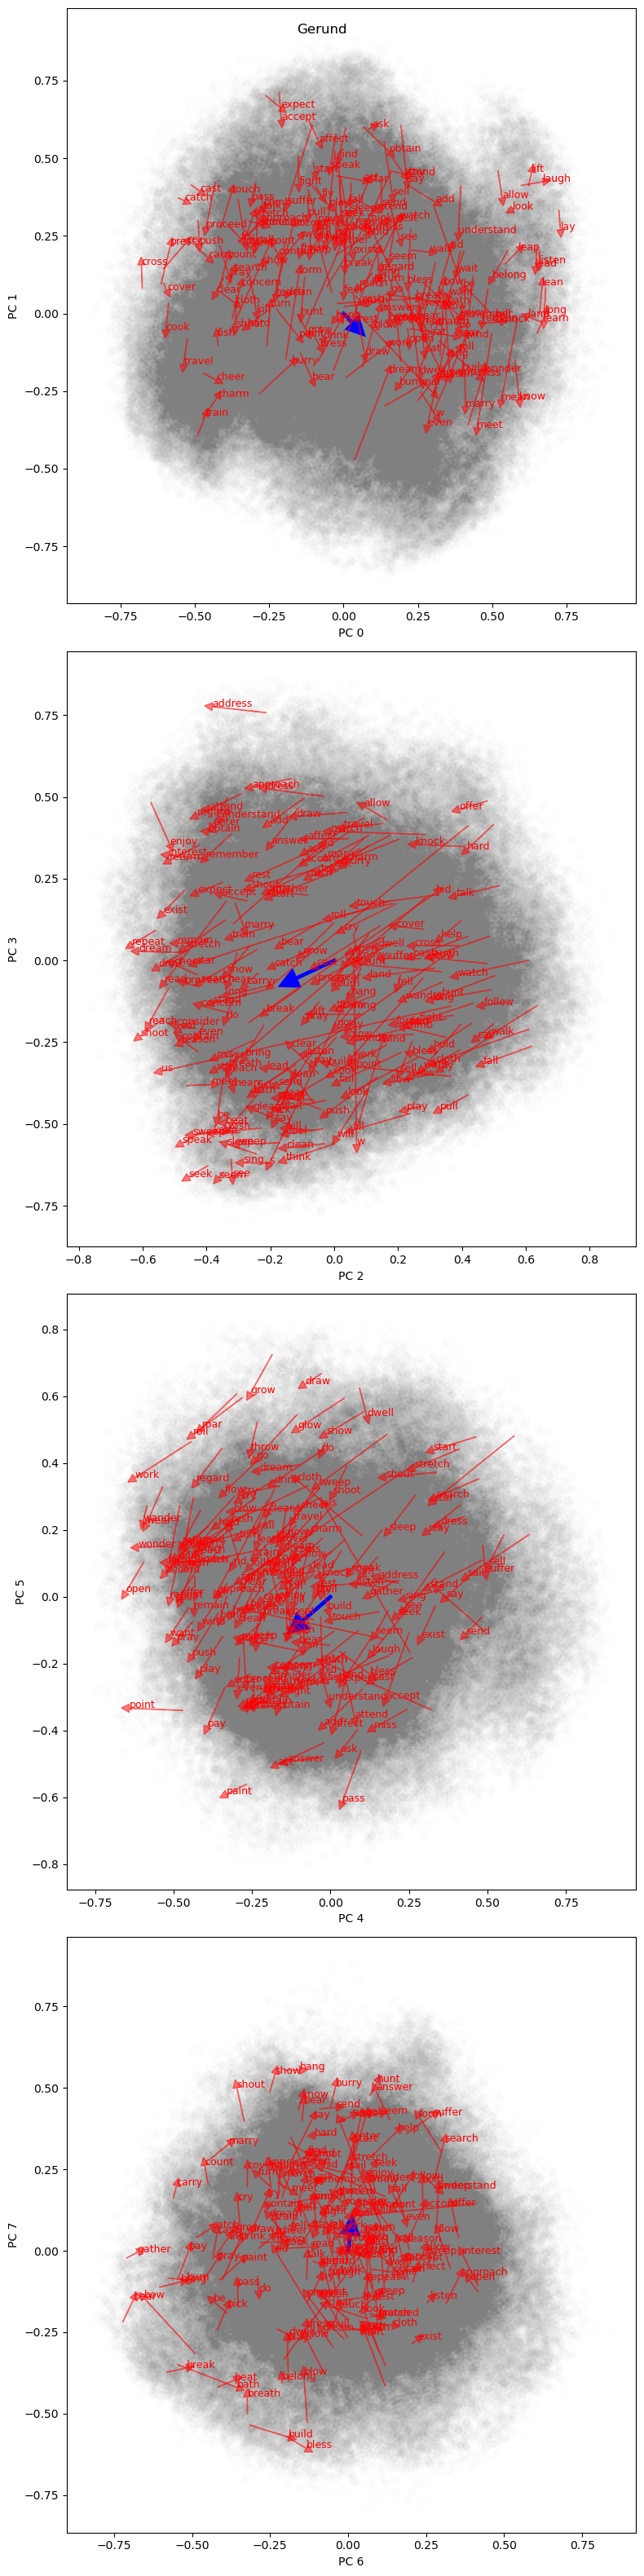

In [206]:
analyze_inflection("Gerund", inflection_relations["gerund"])

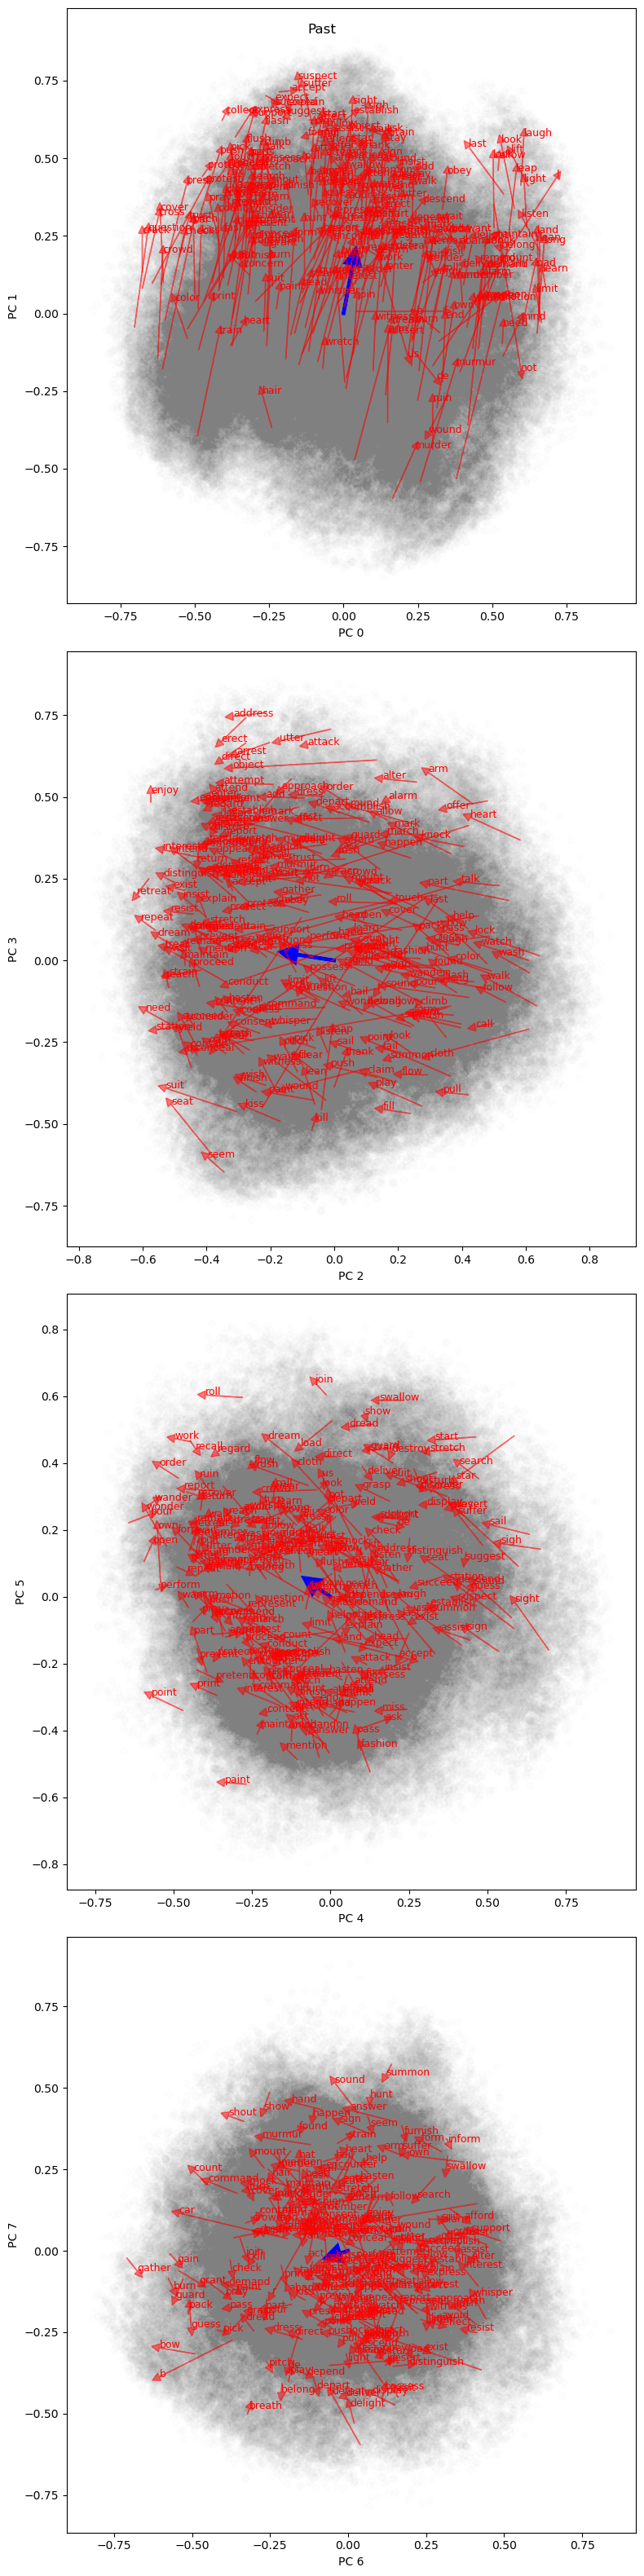

In [207]:
analyze_inflection("Past", inflection_relations["past"])

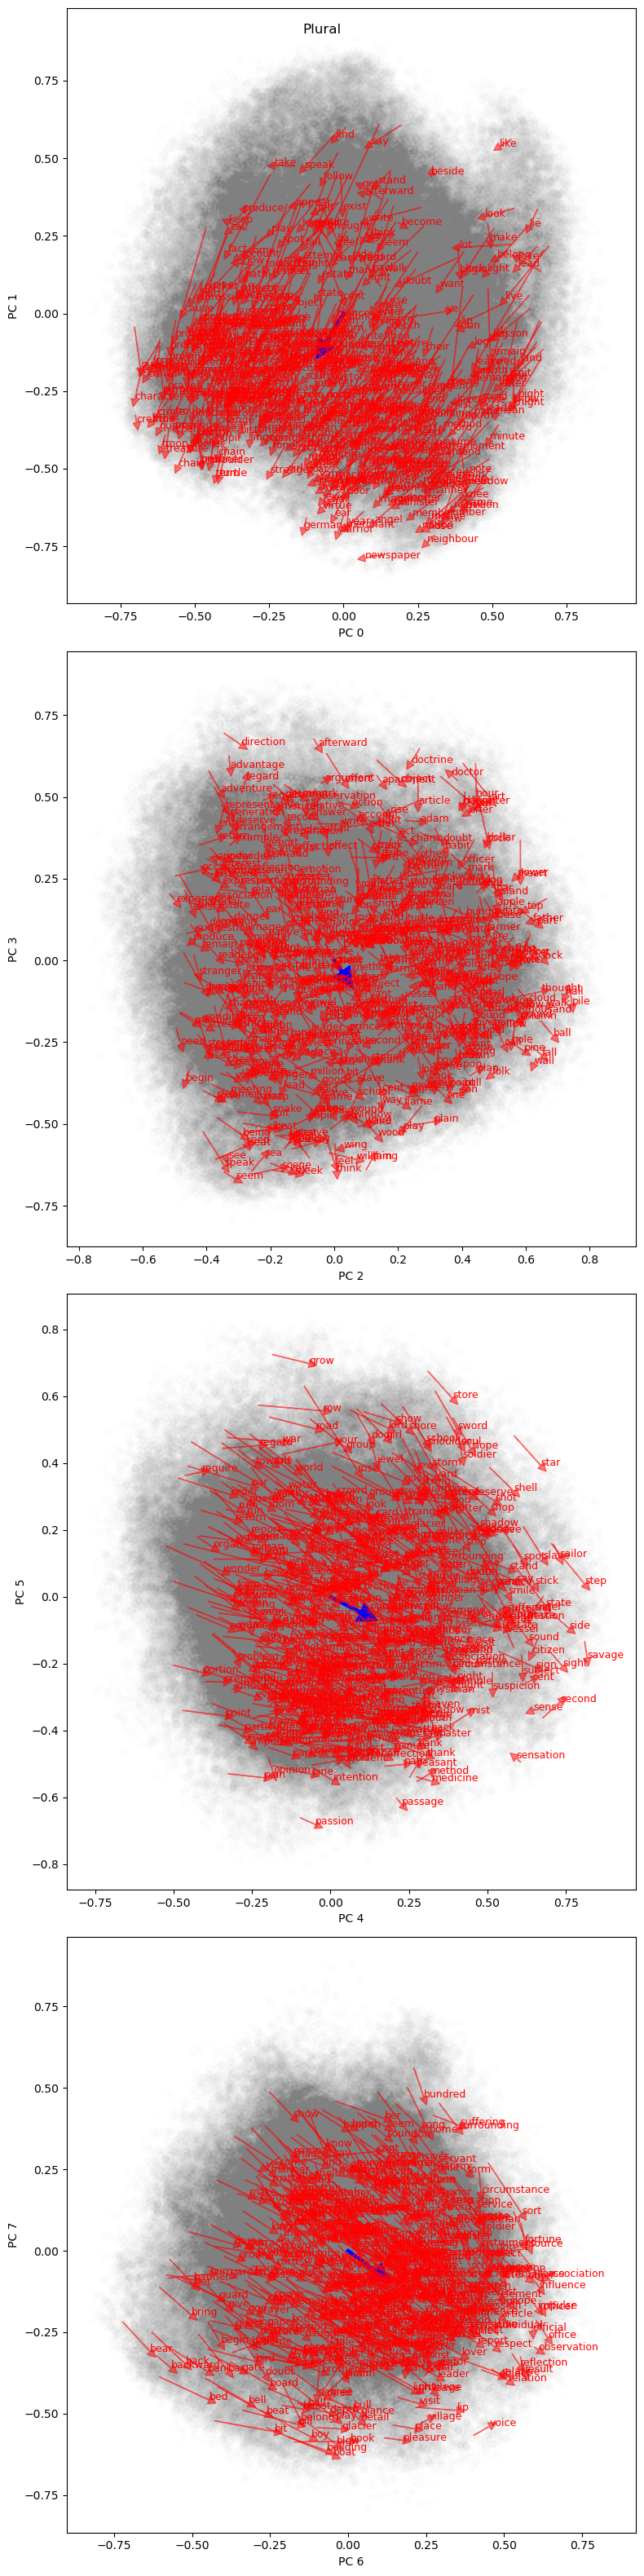

In [210]:
analyze_inflection("Plural", inflection_relations["plural"])

In [216]:
import datasets
ds = datasets.load_dataset("relbert/analogy_questions", "bats") \
    ["test"].filter(lambda x: "morphology" in x["prefix"])

In [217]:
from collections import Counter
Counter(x["prefix"] for x in ds).most_common()

[('./cache/BATS_3.0/2_Derivational_morphology/D03 [adj+ly_reg].txt', 45),
 ('./cache/BATS_3.0/2_Derivational_morphology/D09 [verb+tion_irreg].txt', 45),
 ('./cache/BATS_3.0/1_Inflectional_morphology/I09 [verb_Ving - Ved].txt', 45),
 ('./cache/BATS_3.0/1_Inflectional_morphology/I06 [verb_inf - Ving].txt', 45),
 ('./cache/BATS_3.0/2_Derivational_morphology/D06 [re+verb_reg].txt', 45),
 ('./cache/BATS_3.0/2_Derivational_morphology/D04 [over+adj_reg].txt', 45),
 ('./cache/BATS_3.0/1_Inflectional_morphology/I03 [adj - comparative].txt',
  45),
 ('./cache/BATS_3.0/1_Inflectional_morphology/I10 [verb_3pSg - Ved].txt', 45),
 ('./cache/BATS_3.0/1_Inflectional_morphology/I07 [verb_inf - Ved].txt', 45),
 ('./cache/BATS_3.0/2_Derivational_morphology/D02 [un+adj_reg].txt', 45),
 ('./cache/BATS_3.0/1_Inflectional_morphology/I05 [verb_inf - 3pSg].txt', 45),
 ('./cache/BATS_3.0/1_Inflectional_morphology/I08 [verb_Ving - 3pSg].txt', 45),
 ('./cache/BATS_3.0/2_Derivational_morphology/D05 [adj+ness_reg].